In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pymc3 as pm
import arviz as az


In [2]:
pm.__version__

'3.9.3'

In [3]:
x = np.array([-.86, -.30, -.05, .73])
# n = np.array([5, 5, 5, 5])
y  = np.array([0, 1, 3, 5])

In [4]:
with pm.Model() as m:
    a = pm.Flat('a')
    b = pm.Flat('b')
    n = pm.DiscreteUniform('n', 3, 7)

    logit = a + b * x
    theta = pm.math.invlogit(logit)

    obs = pm.Binomial('obs', p=theta, n=n, observed=y)

In [5]:
#pm.model_to_graphviz(m)



In [16]:
intervals = {
    'b': np.linspace(-10, 40, 200),
    'a': np.linspace(-5, 10, 100),
    'n': [3, 4, 5, 6, 7],
    # 'n': 3,
}

with m:
    #mmap = pm.find_MAP()
    grid = pm.compute_grid(intervals)

In [17]:
g = np.meshgrid(*intervals.values(), indexing='ij')
g = [a.flatten() for a in g]
for i, variables in enumerate(zip(*g)):
    print(i, variables)
    break

0 (-10.0, -5.0)


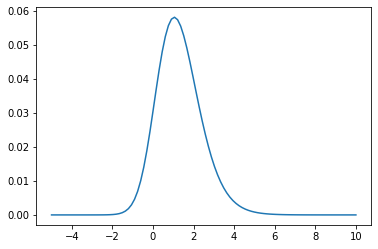

In [18]:
a = grid['a']
plt.plot(a.index, a)

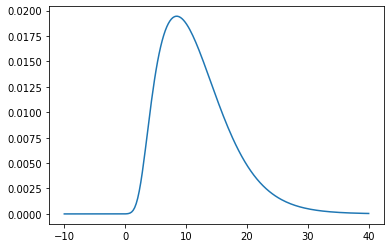

In [19]:
b = grid.marginal('b')
plt.plot(b.index, b)

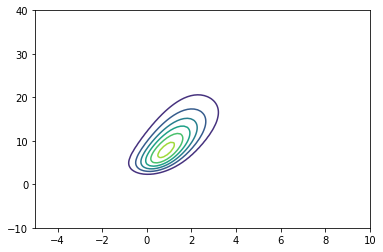

In [10]:
# joint = grid.joint(('b', 'a'))
# joint = grid.marginal(('a', 'b'))
joint = grid[['a', 'b']]
# levels = np.arange(.05, .951, .1)
plt.contour(
    grid.coords['a'],
    grid.coords['b'],
    joint.unstack(level='b').values.T,
    #levels=np.arange(.05, .951, .1)
)

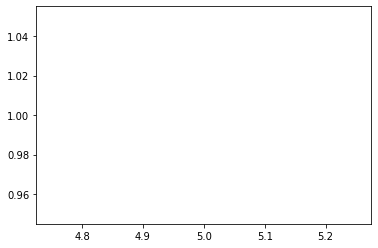

In [11]:
b = grid.marginal('n')
plt.plot(b.index, b)

In [12]:
grid.marginal(['n'])

5    1.0
Name: PMF, dtype: float64